In [1]:
!pip install -q kaggle torchvision scikit-learn matplotlib seaborn

import os, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_recall_curve, roc_curve, classification_report, f1_score
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from google.colab import files

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.9 MB/s eta 0:00:00


In [2]:
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000
!unzip -q skin-cancer-mnist-ham10000.zip
!mkdir -p HAM10000_images
!cp HAM10000_images_part_1/* HAM10000_images/
!cp HAM10000_images_part_2/* HAM10000_images/

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
 99% 5.16G/5.20G [00:35<00:00, 201MB/s]
100% 5.20G/5.20G [00:35<00:00, 156MB/s]


In [3]:
df = pd.read_csv("HAM10000_metadata.csv")
df['label'] = df['dx'].apply(lambda x: 1 if x in ['mel', 'bkl', 'bcc', 'akiec'] else 0)

# Optional: Use smaller data for fast prototyping
df = df.groupby("label").apply(lambda x: x.sample(500, random_state=42)).reset_index(drop=True)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df['label'], random_state=42)

<ipython-input-3-b47fc9c62d72>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("label").apply(lambda x: x.sample(500, random_state=42)).reset_index(drop=True)


In [4]:
class SkinLesionDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.loc[idx, 'image_id'] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'label']
        if self.transform:
            image = self.transform(image)
        return image, label

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Faster training
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def get_loaders(batch_size=32):
    return (
        DataLoader(SkinLesionDataset(train_df, "HAM10000_images", transform), batch_size=batch_size, shuffle=True, num_workers=2),
        DataLoader(SkinLesionDataset(val_df, "HAM10000_images", transform), batch_size=batch_size, num_workers=2),
        DataLoader(SkinLesionDataset(test_df, "HAM10000_images", transform), batch_size=batch_size, num_workers=2)
    )

In [11]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.features.parameters():
        param.requires_grad = False  # Freeze convolutional layers

    # Replace the classifier head
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(in_features, 1)  # 1 output for binary classification
    )
    return model


In [20]:
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5):
    model.to(device)
    best_auc = 0
    history = {'val_auc': []}

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.float().to(device)
            optimizer.zero_grad()
            outputs = model(images).view(-1)  # Updated line
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_labels, val_scores = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images).view(-1)  # Updated line
                probs = torch.sigmoid(outputs)
                val_scores.extend(probs.cpu().numpy())
                val_labels.extend(labels.numpy())

        val_auc = roc_auc_score(val_labels, val_scores)
        print(f"Epoch {epoch+1}: AUC = {val_auc:.4f}")
        history['val_auc'].append(val_auc)

        if val_auc > best_auc:
            best_auc = val_auc
            torch.save(model.state_dict(), "best_model.pth")

    return history



In [21]:
def evaluate(model, test_loader):
    model.eval()
    preds, probs, labels = [], [], []

    with torch.no_grad():
        for images, label in test_loader:
            images = images.to(device)
            outputs = model(images).view(-1)  # Updated line
            prob = torch.sigmoid(outputs)
            pred = (prob > 0.5).float()

            probs.extend(prob.cpu().numpy())
            preds.extend(pred.cpu().numpy())
            labels.extend(label.numpy())

    print(classification_report(labels, preds, target_names=["Non-Cancer", "Cancer"]))
    sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix"); plt.show()


In [22]:
def predict_image(image_path, model):
    model.eval()
    model.to(device)

    image = Image.open(image_path).convert('RGB')
    transform_img = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    img_tensor = transform_img(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        if output.shape[-1] != 1:
            output = output.squeeze()
        prob = torch.sigmoid(output).item()
        pred = "Cancer" if prob > 0.5 else "Non-Cancer"

    print(f"Prediction: {pred} (Probability: {prob:.2f})")
    plt.imshow(image)
    plt.title(pred)
    plt.axis('off')
    plt.show()


Epoch 1: AUC = 0.8684
Epoch 2: AUC = 0.9164
Epoch 3: AUC = 0.8988
Epoch 4: AUC = 0.9116
Epoch 5: AUC = 0.8892
              precision    recall  f1-score   support

  Non-Cancer       0.74      0.80      0.77        50
      Cancer       0.78      0.72      0.75        50

    accuracy                           0.76       100
   macro avg       0.76      0.76      0.76       100
weighted avg       0.76      0.76      0.76       100



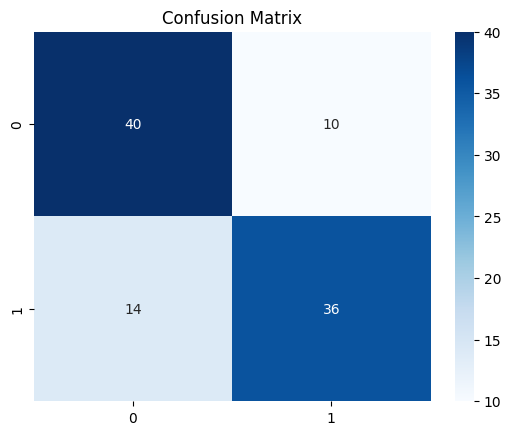

In [23]:
train_loader, val_loader, test_loader = get_loaders(batch_size=32)
model = get_model()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

history = train_model(model, optimizer, criterion, train_loader, val_loader, epochs=5)
model.load_state_dict(torch.load("best_model.pth"))
evaluate(model, test_loader)

Saving ISIC_0029302.jpg to ISIC_0029302.jpg
Prediction: Cancer (Probability: 0.78)


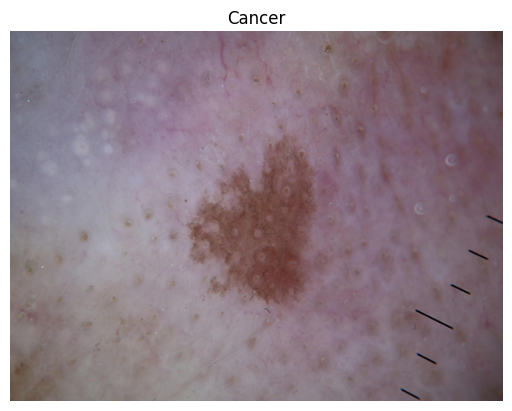

In [25]:

uploaded = files.upload()
img_path = list(uploaded.keys())[0]
predict_image(img_path, model)